In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn import cluster, metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as se
from datetime import datetime
import shap

pd.set_option('display.max_rows', None)
print(np.__version__)

2.0.0


In [24]:
df_bruto = pd.read_csv("weather.csv")
df_bruto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2091 entries, 0 to 2090
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   clouds     2091 non-null   int64  
 1   datetime   2091 non-null   object 
 2   dewpt      2091 non-null   float64
 3   dhi        2091 non-null   int64  
 4   dni        2091 non-null   int64  
 5   ghi        2091 non-null   int64  
 6   precip     2091 non-null   float64
 7   pres       2091 non-null   int64  
 8   rh         2091 non-null   int64  
 9   slp        2091 non-null   int64  
 10  solar_rad  2091 non-null   int64  
 11  temp       2091 non-null   float64
 12  ts         2091 non-null   int64  
 13  wind_dir   2091 non-null   int64  
 14  wind_spd   2091 non-null   float64
dtypes: float64(4), int64(10), object(1)
memory usage: 245.2+ KB


### 1. Lê o Dataframe

In [25]:
df_bruto = pd.read_csv("weather.csv")
df_bruto['datetime'] = pd.to_datetime(df_bruto['datetime'])


In [26]:
df = df_bruto.copy()
df['datetime'] = pd.to_datetime(df['datetime'])

df.head()

,clouds,datetime,dewpt,dhi,dni,ghi,precip,pres,rh,slp,solar_rad,temp,ts,wind_dir,wind_spd
0,69,2019-01-01,18.8,57,453,376,1.0,886,79,1019,319,22.7,1546290000,52,3.2
1,76,2019-01-02,19.0,57,453,376,8.3,884,79,1017,223,23.2,1546376400,54,2.5
2,74,2019-01-03,19.7,57,453,375,11.0,883,82,1015,222,23.0,1546462800,164,1.2
3,94,2019-01-04,19.7,57,453,375,9.8,883,77,1014,157,24.3,1546549200,187,1.5
4,77,2019-01-05,18.9,57,453,375,6.0,882,72,1014,247,24.6,1546635600,191,1.0


### 2. Verificando se existe valores nulos

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2091 entries, 0 to 2090
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   clouds     2091 non-null   int64         
 1   datetime   2091 non-null   datetime64[ns]
 2   dewpt      2091 non-null   float64       
 3   dhi        2091 non-null   int64         
 4   dni        2091 non-null   int64         
 5   ghi        2091 non-null   int64         
 6   precip     2091 non-null   float64       
 7   pres       2091 non-null   int64         
 8   rh         2091 non-null   int64         
 9   slp        2091 non-null   int64         
 10  solar_rad  2091 non-null   int64         
 11  temp       2091 non-null   float64       
 12  ts         2091 non-null   int64         
 13  wind_dir   2091 non-null   int64         
 14  wind_spd   2091 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(10)
memory usage: 245.2 KB


### 5. Função para criação das features

In [28]:
df['temp_next_day'] = df['temp'].shift(-1)

In [6]:
def features_hist(df, dia, core):
    df = df.sort_values('datetime')

    features = ['clouds', 'dewpt', 'dhi', 'dni', 'ghi', 'precip', 'pres', 'rh', 'slp', 'solar_rad', 'temp', 'wind_dir', 'wind_spd']
    
    for feature in features:
        df[f"media_{feature}{core}_{dia}d"] = df[feature].rolling(window=dia, min_periods=1).mean()
        df[f"max_{feature}{core}_{dia}d"] = df[feature].rolling(window=dia, min_periods=1).max()
        df[f"min_{feature}{core}_{dia}d"] = df[feature].rolling(window=dia, min_periods=1).min()
        df[f"mediana_{feature}{core}_{dia}d"] = df[feature].rolling(window=dia, min_periods=1).median()
        df[f"cv_{feature}{core}_{dia}d"] = df[feature].rolling(window=dia, min_periods=1).std() / df[feature].rolling(window=dia, min_periods=1).mean()

    columns_to_return = ['datetime'] + \
        [f"media_{feature}{core}_{dia}d" for feature in features] + \
        [f"max_{feature}{core}_{dia}d" for feature in features] + \
        [f"min_{feature}{core}_{dia}d" for feature in features] + \
        [f"mediana_{feature}{core}_{dia}d" for feature in features] + \
        [f"cv_{feature}{core}_{dia}d" for feature in features]
    
    return df[columns_to_return]


In [7]:
df_features_1d = features_hist(df, 1, "")
df_features_2d = features_hist(df, 2, "")
df_features_3d = features_hist(df, 3, "")
df_features_7d = features_hist(df, 7, "")
df_features_14d = features_hist(df, 14, "")
df_features_30d = features_hist(df, 30, "")

In [8]:
df_final = df.merge(df_features_1d, on = "datetime", how = "left")
df_final = df_final.merge(df_features_2d, on = "datetime", how = "left")
df_final = df_final.merge(df_features_3d, on = "datetime", how = "left")
df_final = df_final.merge(df_features_7d, on = "datetime", how = "left")
df_final = df_final.merge(df_features_14d, on = "datetime", how = "left")
df_final = df_final.merge(df_features_30d, on = "datetime", how = "left")


In [9]:
df_final['day_of_year'] = df_final['datetime'].dt.dayofyear
df_final['month'] = df_final['datetime'].dt.month
df_final['day_of_week'] = df_final['datetime'].dt.dayofweek

In [11]:
X = df_final.drop(columns=['temp_next_day', 'datetime'])  # Retirar a coluna de alvo e a data
y = df_final['temp_next_day']  # Variável alvo

X = X[:-1]
y = y[:-1]

In [12]:
# Instanciar o modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
mae_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Exibir as médias e desvios padrão das métricas
print(f'RMSE médio: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}')
print(f'MAE médio: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}')
print(f'R² médio: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}')

X_last_day = X.iloc[[-1]]

temp_next_day_pred = model.predict(X_last_day)
print(f'Previsão de temperatura para o próximo dia: {temp_next_day_pred[0]:.2f}°C')

c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarnin

RMSE médio: 0.9673 ± 0.0408
MAE médio: 0.7234 ± 0.0312
R² médio: 0.9047 ± 0.0037
Previsão de temperatura para o próximo dia: 18.74°C


c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
next_day_data = X_last_day.copy()
next_day_data['datetime'] = df_bruto['datetime'].max() + pd.Timedelta(days=1)
next_day_data['temp'] = temp_next_day_pred
next_day_data['temp_next_day'] = np.nan 

In [14]:
next_day_data = next_day_data[['clouds', 'datetime', 'dewpt', 'dhi', 'dni', 'ghi', 'precip', 'pres',
       'rh', 'slp', 'solar_rad', 'temp', 'ts', 'wind_dir', 'wind_spd']]

In [15]:
next_day_data

,clouds,datetime,dewpt,dhi,dni,ghi,precip,pres,rh,slp,solar_rad,temp,ts,wind_dir,wind_spd
2089,40,2024-09-27,14.0,48,381,294,2.3,881,79,1000,287,18.737,1727211600,53,3.1


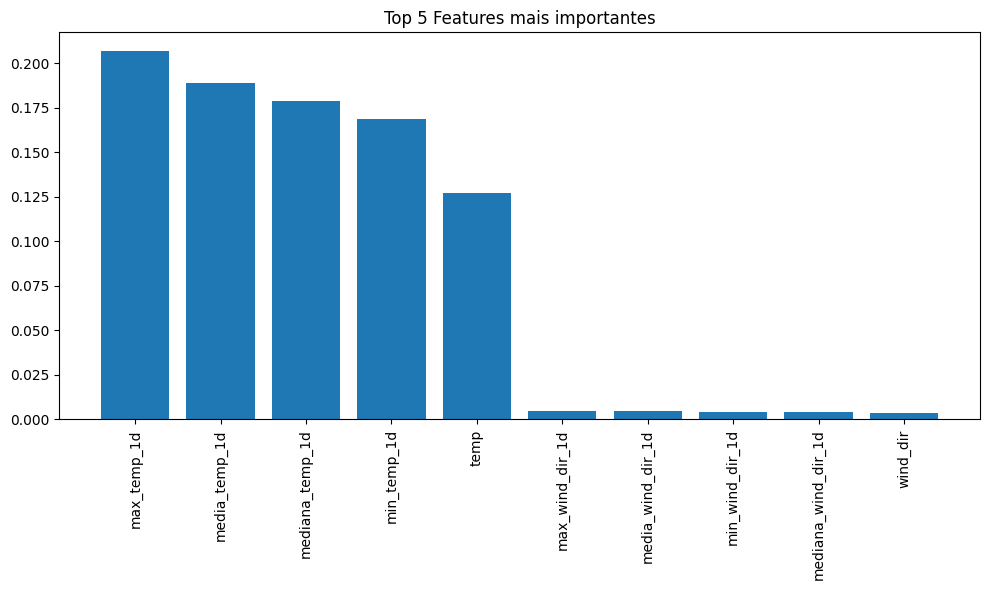

In [22]:
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]


plt.figure(figsize=(10, 6))
plt.title("Top 5 Features mais importantes")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), X.columns[indices[:10]], rotation=90)
plt.tight_layout()
plt.show()


c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


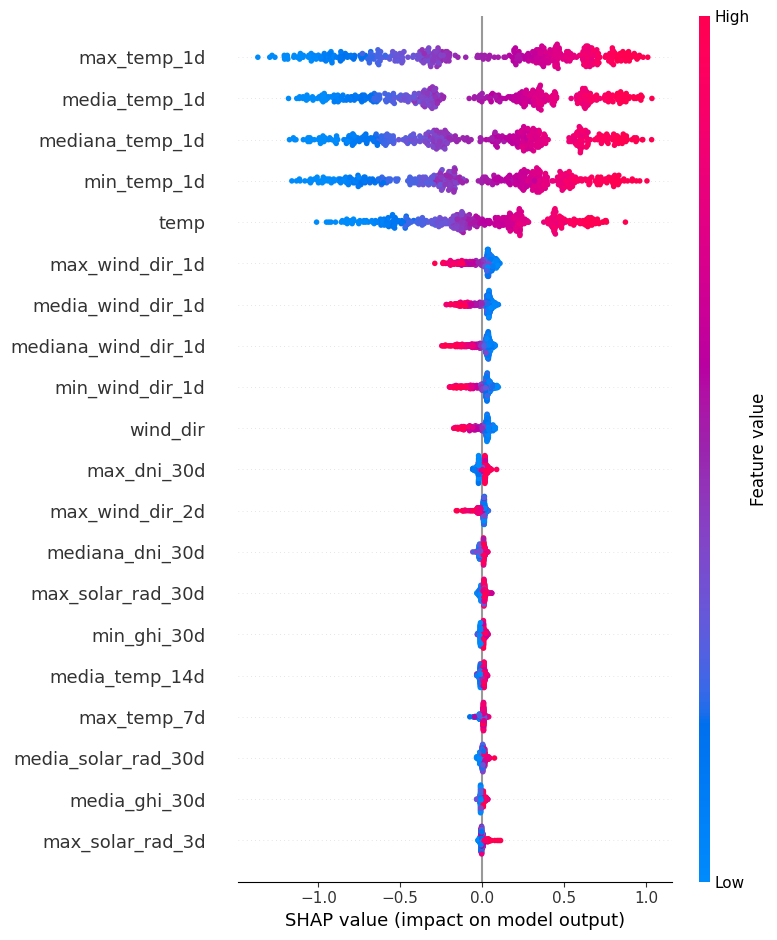

In [17]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0,:])

shap.summary_plot(shap_values, X_test)

In [16]:
import joblib

joblib.dump(model, 'random_forest_weather_model.pkl')


['random_forest_weather_model.pkl']

In [ ]:
se.pairplot(df)